# Introduction to PySpark and MLlib


This notebook contains basic materials and examples/exercises on using pyspark for machine learning via Spark's MLlib (Spark version 1.4.1). MLLib supports the use of Spark dataframe for building the machine learning pipeline. 

https://spark.apache.org/docs/1.4.1/mllib-guide.html


##Why Spark?

Spark as a fast cluster computing platform provides scalability, fault tolerance, and seamless integration with existing big data pipelines. Spark can scale up to hundreds of machines and distribute the computation compare to other machine learning tools such as R, Matlab and Scipy  which run on a single machine. 

Here's a comparison by Databricks (which is founded by the creators of Spark), the running times between R vs MLLib for  Pearson’s correlation on a 32-node cluster

https://databricks.com/blog/2014/08/27/statistics-functionality-in-spark.html

<img src="Spark-vs-R-pearson.png">


## Why PySpark?

Below shows the performance figure for Pyspark Dataframe, which seems to have comparable performance with Scala dataframe

<img src="spark-dataframes-and-ml-pipelines-11-638.jpg">


And also python has plenty of machine learning libaries including scikit-learn

https://wiki.python.org/moin/PythonForArtificialIntelligence

It has has visualization libraries such as matplotlib, ggplot, seaborn etc...


#Overview

For first time users of IPython notebook, the code cells below can be run directly from this note book either by pressing the "play" icon on the top , or by hitting CTRL+ Enter key. The profile setup for this IPyThon notebook allows PySpark API to be called directly from the code cells below. On top of that, the Anaconda Python distribution has also been installed which include common libraries such as numpy, scikit-learn, scipy, pandas etc. 



This exercise will go through the building of a machine learning pipeline with MLlib for classification purpose.
The exercise includes:
- loading the data into Spark dataframe
- preprocessing the raw data
- feature extraction/transformation
- training classification model
- creating machine learning pipeline to wrap the featurization and classifications
- hyperparameters tuning and cross validation


## Dataset - Prediction for Bank direct marketing Campaign

The following exercises on PySpark will be applied to a classifcation problem on a data set obtained from UCI Machine Learning Repository.

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

This data has already been loaded into your VM and its available under the data/ folder which you can view from Jupyter.

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). This is basically a binary classifcation, where the predicted classes is either yes or no.
Some of the headings has been renamed for clarity purpose.

###Attribute Information:

| Position | Heading | Description | Values |       
| :- |:-- |:------------------------------------ | :------------|
|1| age (numeric)  | | |
|2| job  | |'admin.','blue-collar','entrepreneur','housemaid', 'management','retired','self-employed','services','student','technician','unemployed','unknown'|
|3| marital  | | 'divorced','married','single','unknown'|
|4| education | |'basic.4y','basic.6y','basic.9y','high.school', 'illiterate','professional.course','university.degree','unknown'|
|5| default | has credit in default? | 'no','yes','unknown'|
|6| housing | has housing loan?  | 'no','yes','unknown'|
|7| loan | has personal loan? | 'no','yes','unknown'|
|8| contact | contact communication type  | 'cellular','telephone'|
|9| month | last contact month of year| 'jan', 'feb', 'mar', ..., 'nov', 'dec'|
|10| day_of_week |last contact day of the week|'mon','tue','wed','thu','fri'|
|11| duration |last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.||
|12| campaign |number of contacts performed during this campaign and for this client (numeric, includes last contact)||
|13| pdays |number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)||
|14| previous |number of contacts performed before this campaign and for this client (numeric)||
|15| outcome_of_prev | outcome of the previous marketing campaign |'failure','nonexistent','success'|
|16| emp_variation_rate | employment variation rate - quarterly indicator (numeric) ||
|17|consumer_price_idx | consumer price index - monthly indicator (numeric)  ||
|18|consumer_conf_idx| consumer confidence index - monthly indicator (numeric)   ||
|19|euribor3m|euribor 3 month rate - daily indicator (numeric)  ||
|20|num_of_employees|number of employees - quarterly indicator (numeric) ||
|21|has_subscribed|has the client subscribed a term deposit?  Note: This is not an attribute, rather the label of the observations | 'yes','no'|



#  1. First up, Loading the data

SparkSql core supports various datasource such as Parquet, Json , Avro etc.
However for CSV, it requires to use additional Spark Package. Currently theres the following options of spark-csv by Databricks guys, and pyspark_csv. 

https://github.com/seahboonsiew/pyspark-csv

https://github.com/databricks/spark-csv

Pyspark_csv was selected due to its ability in inferring the schema, as compared to spark-csv which defaults all columns to string types.  :(


In [1]:
import os.path
import pyspark_csv as pycsv

#import the spark package for importing csv
sc.addPyFile('pyspark_csv.py')

#read in the csv data file
fileName = os.path.join('data', 'bank-additional-full-data.csv')
plainTextRdd = sc.textFile(fileName)
rawDataFrame = pycsv.csvToDataFrame(sqlContext, plainTextRdd, parseDate=False)

#Have a look at the schema of the data frame created
rawDataFrame.printSchema()



root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- outcome_of_prev: string (nullable = true)
 |-- emp_variation_rate: double (nullable = true)
 |-- consumer_price_idx: double (nullable = true)
 |-- consumer_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- num_employees: double (nullable = true)
 |-- has_subscribed: string (nullable = true)



## 2. Data Preprocessing

Preprocess the data if required.

As noted above, the "duration" column should not be used as part of the features as it wont be known till phone calls.
So next step we going to remove the duration column. 

    
There's no missing values in the datasets. If replacement of missing values is required, we could use the Dataframe.fillna function (similar to pandas).


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction

# Number of records
print "Number of observations originally: %s" % rawDataFrame.count()
print "Number of columns originally: %s" % len(rawDataFrame.columns)

#Remove duration column as its only for benchmark purpose. We wont know duration till after we know the outcome of
#whether the customer signed up for the term deposit.
filteredDf = rawDataFrame.drop("duration")

print "Number of filtered observations: %s" % filteredDf.count()
print "Number of columns after drop: %s" % len(filteredDf.columns)

#view some summary of the columns
filteredDf.describe("age").show()
filteredDf.describe("pdays").show()
filteredDf.describe("emp_variation_rate").show()



Number of observations originally: 41188
Number of columns originally: 21
Number of filtered observations: 41188
Number of columns after drop: 20
+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             41188|
|   mean| 40.02406040594348|
| stddev|10.421123471838722|
|    min|                17|
|    max|                98|
+-------+------------------+

+-------+-----------------+
|summary|            pdays|
+-------+-----------------+
|  count|            41188|
|   mean|962.4754540157328|
| stddev|186.9086383338419|
|    min|                0|
|    max|              999|
+-------+-----------------+

+-------+------------------+
|summary|emp_variation_rate|
+-------+------------------+
|  count|             41188|
|   mean|0.0818855006314648|
| stddev|1.5709406698013302|
|    min|              -3.4|
|    max|               1.4|
+-------+------------------+



The label column currently is in string format. But the MLlib classifiers such as Logistic regression and decision trees expect the Dataframe to contain the following structures for training:
    - "features" : single vector column representing the feature vectors for the observation 
    - "label": double type, representing the label

In [3]:
#Add the label column , that basically corresponds to the has_subscribed column
toDouble = UserDefinedFunction(lambda x: 1. if x == "yes" else 0., DoubleType())
filteredDf = filteredDf.withColumn("label", toDouble(filteredDf["has_subscribed"]))
filteredDf.show(3)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|outcome_of_prev|emp_variation_rate|consumer_price_idx|consumer_conf_idx|euribor3m|num_employees|has_subscribed|label|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|       1|  999|       0|    nonexistent|               1.1|            93.994|            -36.4|    4.857|       5191.0|            no|  0.0|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|       1|  9

+--------------+-----+
|has_subscribed|count|
+--------------+-----+
|            no|36548|
|           yes| 4640|
+--------------+-----+



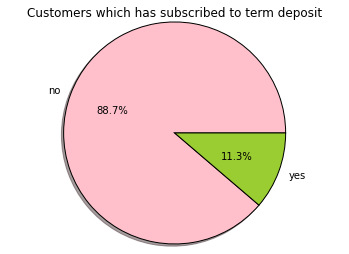

In [4]:
import matplotlib.pyplot as plt


#Show number of customers that have signed up term deposit vs those that did not
numOfSignUps = filteredDf.groupBy("has_subscribed").count()
numOfSignUps.show()

#plot labels
labels = numOfSignUps.map(lambda row: row.has_subscribed).collect()
sizes = numOfSignUps.map(lambda row: row.count).collect()
colors = ['pink', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors, shadow=True,autopct='%1.1f%%')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Customers which has subscribed to term deposit')
plt.show()


In [5]:
# Register this DataFrame as a table.
filteredDf.registerTempTable("campaign")

#run sql queries
queryResult = sqlContext.sql("SELECT age, job, marital FROM campaign WHERE has_subscribed = 'yes'")
queryResult.show()


+---+------------+--------+
|age|         job| marital|
+---+------------+--------+
| 41| blue-collar|divorced|
| 49|entrepreneur| married|
| 49|  technician| married|
| 41|  technician| married|
| 45| blue-collar| married|
| 42| blue-collar| married|
| 39|   housemaid| married|
| 28|     unknown|  single|
| 44|    services| married|
| 42|  technician| married|
| 42|  management| married|
| 39|    services| married|
| 42| blue-collar| married|
| 45|   housemaid| married|
| 31|      admin.|  single|
| 28|     student|  single|
| 41|entrepreneur| married|
| 37| blue-collar|  single|
| 44| blue-collar| married|
| 44|entrepreneur| married|
+---+------------+--------+



## 3. Splitting Datasets


Training the model and testing it on the same data could be a problem: a model that would just repeat the labels of the observations that it has seen would have a perfect score but would fail to predict anything useful on newly-unseen data. This situation is called overfitting. 

To avoid overfitting, it is common practice when training a (supervised) machine learning model to split the available data into training, test and validation sets. 

We will create 3 sets of data:
- training set : for training our classification models
- validation set : for evaluating the performance of our trained models (and tuning the parameters (hyperparamters) of the mdoels)
- test set: for testing the models (unseen samples, not used in training nor model selection)

Our goal is to create model that can generalized well to the dataset and avoid overfitting.



In [6]:
# split into training(60%), validation(20%) and test(20%) datasets
trainingRdd, validationRdd, testRdd = filteredDf.rdd.randomSplit([6, 2, 2], seed=0L)
trainingDf = trainingRdd.toDF() 
validationDf = validationRdd.toDF() 
testDf = testRdd.toDF() 

print trainingDf.take(1)

#lets cache these datasets
trainingDf.cache()
validationDf.cache()
testDf.cache()

print "Num of training observations : %s" % trainingDf.count()
print "Num of validation observations : %s" % validationRdd.count()
print "Num of test observations : %s" % testDf.count()

[Row(age=57, job=u'services', marital=u'married', education=u'high.school', default=u'unknown', housing=u'no', loan=u'no', contact=u'telephone', month=u'may', day_of_week=u'mon', campaign=1, pdays=999, previous=0, outcome_of_prev=u'nonexistent', emp_variation_rate=1.1, consumer_price_idx=93.994, consumer_conf_idx=-36.4, euribor3m=4.857, num_employees=5191.0, has_subscribed=u'no', label=0.0)]
Num of training observations : 24721
Num of validation observations : 8225
Num of test observations : 8242


## 4. Categorical Feature Transformation

For the categorical attributes, we need to convert those text-based categories into numeric features before attempting to train/build a classification model with these data. 

For example, the attribute of "marital", is a categorical feature with 4 possible values of 'divorced','married','single','unknown'. 

We will be using the out-of-the-box MLlib featurization technique named one hot encoding to transform such categorical features into a feature vectors consist of binary 0s and 1s. Refer to the MLLib documentation for more information about one hot encoding
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html

VectorAssembler is used to assemble the feature vectors.

If the variables in the feature vectors has too huge of scale difference, you might like to normalize it with feature scaling. MLlib offers standardScaler aspart of the pyspark.mllib. Other dimensionality reduction techniques available include PCA and SVD.



In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

#convert the categorical attributes to binary features
categoricalAttributes = ['job', 'marital', 'education', 'default', 
                         'housing', 'loan', 'contact', 
                         'month', 'day_of_week', 'outcome_of_prev']

#Build a list of pipelist stages for the machine learning pipeline. 
#start by the feature transformer of one hot encoder for building the categorical features
pipelineStages = []
for columnName in categoricalAttributes:
    stringIndexer = StringIndexer(inputCol=columnName, outputCol=columnName+ "Index")
    pipelineStages.append(stringIndexer)
    oneHotEncoder = OneHotEncoder(inputCol=columnName+ "Index", outputCol=columnName + "Vec")
    pipelineStages.append(oneHotEncoder)


print "%s string indexer and one hot encoders transformers" %  len(pipelineStages) 
assert len(pipelineStages) == len(categoricalAttributes)*2

# Combine all the feature columns into a single column in the dataframe
numericColumns = ['age', 'campaign', 'pdays', 'previous',
           'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 
                  'euribor3m', 'num_employees']
categoricalCols = [s + "Vec" for s in categoricalAttributes]
allFeatureCols =  numericColumns + categoricalCols
vectorAssembler = VectorAssembler(
    inputCols=allFeatureCols,
    outputCol="features")
pipelineStages.append(vectorAssembler)
print "%s feature columns: %s" % (len(allFeatureCols),allFeatureCols)


#Build pipeline for feature extraction
featurePipeline = Pipeline(stages=pipelineStages)
featureOnlyModel = featurePipeline.fit(trainingDf)

20 string indexer and one hot encoders transformers
19 feature columns: ['age', 'campaign', 'pdays', 'previous', 'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 'euribor3m', 'num_employees', 'jobVec', 'maritalVec', 'educationVec', 'defaultVec', 'housingVec', 'loanVec', 'contactVec', 'monthVec', 'day_of_weekVec', 'outcome_of_prevVec']


In [9]:
#create list of Dataframes with features
trainingFeaturesDf = featureOnlyModel.transform(trainingDf)
validationFeaturesDf = featureOnlyModel.transform(validationDf)
testFeaturesDf = featureOnlyModel.transform(testDf)

#peek
trainingFeaturesDf.select("features", "label").rdd.take(2)

[Row(features=SparseVector(52, {0: 57.0, 1: 1.0, 2: 999.0, 4: 1.1, 5: 93.994, 6: -36.4, 7: 4.857, 8: 5191.0, 12: 1.0, 20: 1.0, 24: 1.0, 31: 1.0, 33: 1.0, 34: 1.0, 37: 1.0, 47: 1.0, 50: 1.0}), label=0.0),
 Row(features=SparseVector(52, {0: 37.0, 1: 1.0, 2: 999.0, 4: 1.1, 5: 93.994, 6: -36.4, 7: 4.857, 8: 5191.0, 12: 1.0, 20: 1.0, 24: 1.0, 30: 1.0, 32: 1.0, 34: 1.0, 37: 1.0, 47: 1.0, 50: 1.0}), label=0.0)]

## 5. Unsupervised classification - Clustering with Gaussian Mixture

MLLib offers some clustering methods. This could be useful when you are dealing with unlabeled data, where its impossible to apply supervised learning algorithms.

List of supporting clustering techniques out of the box by Spark currently are:
- K-means
- Gaussian mixture
- Power iteration clustering (PIC)
- Latent Dirichlet allocation (LDA)
- Streaming k-means

Lets train a Gaussian mixture model and see how it performs with our current featureset


In [11]:
from pyspark.mllib.clustering import KMeans, KMeansModel, GaussianMixture
from numpy import array
from math import sqrt

# Extract the "features" from the training set into vector format 
def extractVectorFeatures(featuresDf):
    return featuresDf.select("features").rdd.map(lambda row: row.features)

#function to calculate the accuracy
def calculateAccuracy(labelsAndPredictionsRdd):
    """""
        Calculate accuracy for a given label and prediction RDD
        input:  
            labelsAndPredictionsRdd : RDD consisting of tuples (label, prediction)
        
        return: float accuracy in percentage
    """""
    return (labelsAndPredictionsRdd.filter(lambda (l, p): l == p).count() 
            / float(labelsAndPredictionsRdd.count())* 100)

# Build the model (cluster the data)
trainingRdd = extractVectorFeatures(trainingFeaturesDf)

numOfClusters = 2
gmm = GaussianMixture.train(trainingRdd, numOfClusters)

def getGmmPredictedAccuracy(featuresDf, featuresRdd, model):
    #run the prediction on the featuresRdd
    predictionList = model.predict(featuresRdd).collect()
    actualAndPred = (featuresDf.select("label").rdd
            .map(lambda row: row.label)
            .zipWithIndex()
            .map(lambda (l, i): (l, predictionList[i])) )
    #map the training features data frame to the predicted labels list by index
    return calculateAccuracy(actualAndPred)

# Predict training set with GMM cluster model
trainGmmAccuracy = getGmmPredictedAccuracy(trainingFeaturesDf, trainingRdd, gmm)

#repeat with test set
testRdd = extractVectorFeatures(testFeaturesDf)
testGmmAccuracy = getGmmPredictedAccuracy(testFeaturesDf, testRdd, gmm)

#repeat with validation set
validationRdd = extractVectorFeatures(validationFeaturesDf)
validationGmmAccuracy = getGmmPredictedAccuracy(validationFeaturesDf, validationRdd, gmm)

print "=========================================="
print("GMM accuracy against unfiltered training set(%) = " + str(trainGmmAccuracy))
print("GMM accuracy against test set(%) = " + str(testGmmAccuracy))
print("GMM accuracy against validation set(%) = " + str(validationGmmAccuracy))
print "=========================================="


GMM accuracy against unfiltered training set(%) = 88.9688928441
GMM accuracy against test set(%) = 88.5100703713
GMM accuracy against validation set(%) = 88.2553191489


## 6. Supervised Learning

In the previous steps, we have chain together a list of feature encoders to encode our categorical features.
Next we will proceed to use MLlib Pipeline api to build the ML pipeline. The advantage of the pipeline API is that it bundles and chains the transformers (feature encoders, feature selectors etc) and estimators (trained model) together and make it easier for reusability.

https://spark.apache.org/docs/latest/ml-guide.html#migration-guide

Pyspark API documentation on classification
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/classification.html

We will create a logistic regression model where the model makes predictions by applying the logistic function. The hyperparameters for a logistic regression model includes:
- regularization parameter (regParam) to prevent overfitting by penalizing models with extreme parameter values



In [12]:
from pyspark.ml.classification import LogisticRegression

# Configure an machine learning pipeline, which consists of the 
# an estimator (classification) (Logistic regression)
lr = LogisticRegression(maxIter=10, regParam=0.01)
lrPipeline = Pipeline(stages=[lr])

# Fit the pipeline to create a model from the training data
lrPipelineModel = lrPipeline.fit(trainingFeaturesDf)

def getAccuracyForPipelineModel(featuresDf, model):
    #perform prediction using the featuresdf and pipelineModel
    #compute the accuracy in percentage float
    results = model.transform(featuresDf)
    labelsAndPreds = results.map(lambda p: (p.label, p.prediction))
    return (calculateAccuracy(labelsAndPreds), results) 

# Evaluating the model on training data
lrTrainAccuracy, lrTrainResultDf = getAccuracyForPipelineModel(trainingFeaturesDf, lrPipelineModel)

# Repeat on test data
lrTestAccuracy, lrTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, lrPipelineModel)

# Repeat on validation data
lrValidationAccuracy, lrValidationResultDf = getAccuracyForPipelineModel(validationFeaturesDf, lrPipelineModel)

print "=========================================="
print("LogisticRegression Model training accuracy (%) = " + str(lrTrainAccuracy))
print("LogisticRegression Model test accuracy (%) = " + str(lrTestAccuracy))
print("LogisticRegression Model validation accuracy (%) = " + str(lrValidationAccuracy))
print "=========================================="


LogisticRegression Model training accuracy (%) = 89.9842239392
LogisticRegression Model test accuracy (%) = 89.4079107013
LogisticRegression Model validation accuracy (%) = 89.1063829787


In [14]:
#you can create a pipeline combining multiple pipelines 
#(e.g feature extraction pipeline, and classification pipeline)
combinedPipeline = Pipeline(stages= [featurePipeline, lrPipeline])


In [13]:
# Run the prediction with our trained model on test data (which has not been used in training)
# Make predictions on test observations and print results.
selected = lrTestResultDf.select("has_subscribed", "label", "prediction")

#Show number of predicted results
predictedLabel = selected.groupBy("prediction").count()
predictedLabel.show()

selected.show(20)

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|  278|
|       0.0| 7964|
+----------+-----+

+--------------+-----+----------+
|has_subscribed|label|prediction|
+--------------+-----+----------+
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
+--------------+-----+----------+



## Hyperparameter Tuning with Grid search

One of the important task in machine learning is to use data to find the optimal parameters for our model to perform classification.


In the following section, we will try to train the Logistic Regression model with different values for regularization parameter (regParam) and number of maximum iterations. The accuracy of the model is validated with the validation dataset which we created earlier on.

The best parameters is selected based on this.

In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
from math import log

maxIterRange = [5, 10, 30, 50, 100]
regParamRange = [1e-10, 1e-5, 1e-1]
#baseline values from previous section
bestIter = 10
bestRegParam = 0.01
bestModel = lr
bestAccuracy = lrValidationAccuracy

#for plotting purpose
iterations = []
regParams = []
accuracies = []
for maxIter in maxIterRange:
    for rp in regParamRange:
        currentLr = LogisticRegression(maxIter=maxIter, regParam=rp)
        pipeline = Pipeline(stages=[currentLr])
        model = pipeline.fit(trainingFeaturesDf)
        
        #use validation dataset test for accuracy
        accuracy, resultDf = getAccuracyForPipelineModel(validationFeaturesDf, model)
        print "maxIter: %s, regParam: %s, accuracy: %s " % (maxIter, rp, accuracy)
        accuracies.append(accuracy)
        regParams.append(log(rp))
        iterations.append(maxIter)
        
        if accuracy > lrValidationAccuracy:
            bestIter = maxIter
            bestRegParam = rp
            bestModel = model
            bestAccuracy = accuracy


print "Best parameters: maxIter %s, regParam %s, accuracy : %s" % (bestIter, bestRegParam, bestAccuracy)

# Repeat on test data
gridTestAccuracy, gridTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, bestModel)

print "=========================================="
print("Grid search Model test accuracy (%) = " + str(gridTestAccuracy))
print "=========================================="


maxIter: 5, regParam: 1e-10, accuracy: 88.2553191489 
maxIter: 5, regParam: 1e-05, accuracy: 88.2553191489 
maxIter: 5, regParam: 0.1, accuracy: 88.2553191489 
maxIter: 10, regParam: 1e-10, accuracy: 89.1063829787 
maxIter: 10, regParam: 1e-05, accuracy: 89.1063829787 
maxIter: 10, regParam: 0.1, accuracy: 89.2279635258 
maxIter: 30, regParam: 1e-10, accuracy: 89.4711246201 
maxIter: 30, regParam: 1e-05, accuracy: 89.4711246201 
maxIter: 30, regParam: 0.1, accuracy: 89.3130699088 
maxIter: 50, regParam: 1e-10, accuracy: 89.4589665653 
maxIter: 50, regParam: 1e-05, accuracy: 89.4589665653 
maxIter: 50, regParam: 0.1, accuracy: 89.3495440729 
maxIter: 100, regParam: 1e-10, accuracy: 89.4224924012 
maxIter: 100, regParam: 1e-05, accuracy: 89.4346504559 
maxIter: 100, regParam: 0.1, accuracy: 89.3373860182 
Best parameters: maxIter 100, regParam 0.1, accuracy : 89.3373860182
Grid search Model test accuracy (%) = 89.4928415433


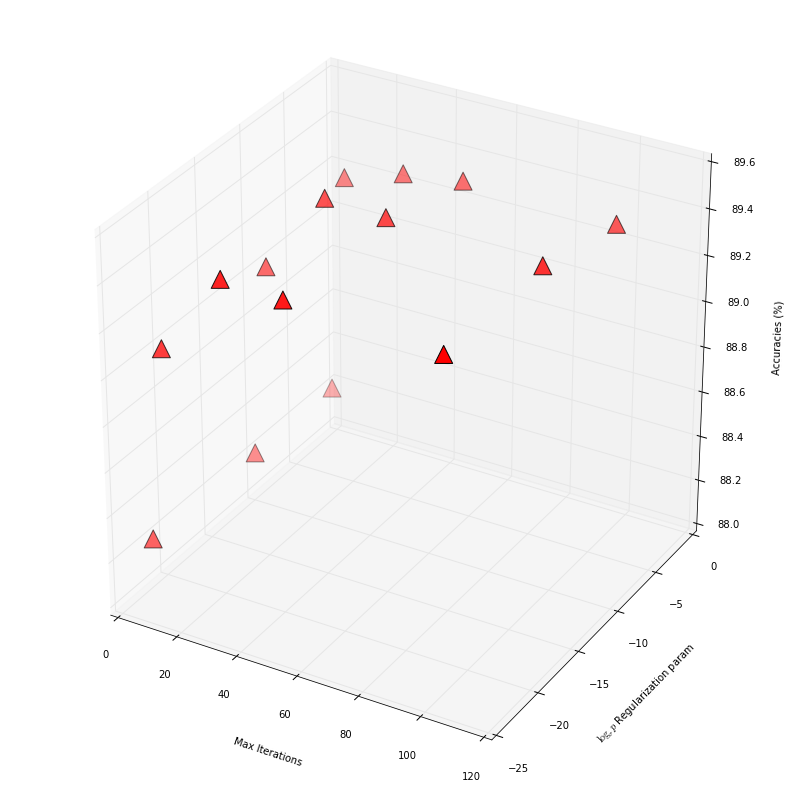

In [81]:
#visualize the results
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(14, 14), facecolor='white', edgecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iterations, regParams, accuracies, 
           s=18**2, c='r', marker='^')

ax.legend()
ax.set_xlabel('Max Iterations')
ax.set_ylabel(r'$\log_rp$ Regularization param')
ax.set_zlabel('Accuracies (%)')


plt.show()

In [17]:

# We use a ParamGridBuilder to construct a grid of parameters to search over.
grid = (ParamGridBuilder()
        .addGrid(lr.maxIter, maxIterRange) 
        .addGrid(lr.regParam,regParamRange )
        .build())


evaluator = BinaryClassificationEvaluator()

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
crossValidator = CrossValidator(estimator=lrPipeline, 
                                estimatorParamMaps=grid, 
                                numFolds=5,
                                evaluator=evaluator)


# Run cross-validation, and choose the best model
bestCvModel = crossValidator.fit(trainingFeaturesDf)

# verify results on training dataset
cvTrainAccuracy, cvTrainResultDf = getAccuracyForPipelineModel(trainingFeaturesDf, bestCvModel)

# Repeat on test data
cvTestAccuracy, cvTestResultDf = getAccuracyForPipelineModel(testFeaturesDf, bestCvModel)

print "=========================================="
print("CV Model training accuracy (%) = " + str(cvTrainAccuracy))
print("CV Model test accuracy (%) = " + str(cvTestAccuracy))
print "=========================================="


Cross validated Model training accuracy (%) = 90.319970875
Cross validated Model test accuracy (%) = 89.6748362048
